 # Problématique :


*Quels sont les facteurs déterminants influençant la performance des joueurs de football et comment ces facteurs peuvent-ils être exploités par les clubs pour améliorer les stratégies de recrutement, de formation et de développement des joueurs afin d'optimiser les résultats sur le terrain ?*


# Presentation Globale sur la database ( Performance of Football players )

Cette base de données offre un aperçu exhaustif des performances individuelles des joueurs de football à travers différents clubs. Elle inclut des informations essentielles telles que le nom, le numéro de maillot, le club, la position, la nationalité, et l'âge des joueurs. De plus, elle détaille les statistiques clés de performance, y compris le nombre d'apparitions, de victoires, de défaites, de buts marqués, ainsi que les cartons jaunes et rouges. Pour les gardiens de but, des données spécifiques comme les plongeons, les prises de balle, et les dégagements sont également enregistrées. Cette richesse d'informations permet d'analyser en profondeur l'impact et la contribution des joueurs au sein de leurs équipes, facilitant ainsi une évaluation globale de leurs compétences et performances sur le terrain.

## Source : https://www.kaggle.com/code/desalegngeb/english-premier-league-players-statistics/input

## Imports

In [1]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
warnings.filterwarnings('ignore')

## Read Data

In [2]:
data = pd.read_csv('Football_Performance.csv', encoding='ISO-8859-1')

## A pie to show the partition of teams

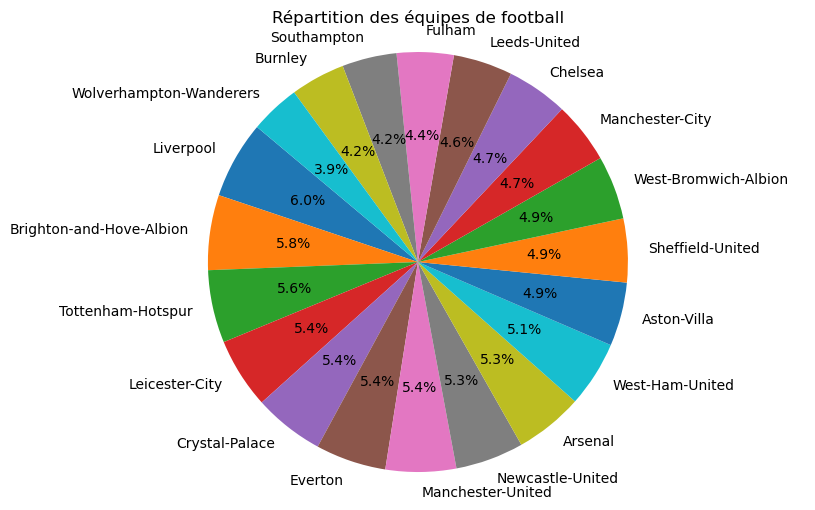

In [3]:
# Calculer la fréquence des labels
freq_labels = data['Club'].value_counts()
# Données
labels = freq_labels.index
sizes = freq_labels.values
# Création du diagramme à secteurs
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Assure que le diagramme est dessiné en cercle
plt.title('Répartition des équipes de football')
plt.show()

# Question Pertinente

1) Existe-t-il une corrélation entre l'âge des joueurs et leur performance ?
2) Les équipes avec un plus grand nombre de tacles réussis ont-elles tendance à encaisser moins de buts ?


# 1. Question 1 (Corrélation entre l'age des jouers et leur performance)

## Creation du Codebook

In [4]:
# Create a codebook
codebook = pd.DataFrame(columns=['Variable', 'Description', 'Data Type', 'Sample Values'])
# Populate the codebook with information
variables = {
    'Age': 'Age of the player in years',
    'Goals': 'Number of goals scored by the player',
    'Position': 'Playing position on the field',
    'Assists': 'Number of assists made by the player',
    'Appearances': 'Number of appearances in games'
}
for var, desc in variables.items():
    data_type = data[var].dtype
    sample_values = data[var].dropna().unique()[:]  # Show up to 5 unique values as examples
    codebook = pd.concat([codebook, pd.DataFrame({
        'Variable': [var],
        'Description': [desc],
        'Data Type': [data_type],
        'Sample Values': [', '.join(map(str, sample_values))]
    })], ignore_index=True)
# Display the codebook
codebook


,Variable,Description,Data Type,Sample Values
0,Age,Age of the player in years,float64,"28.0, 26.0, 25.0, 23.0, 19.0, 32.0, 33.0, 27.0..."
1,Goals,Number of goals scored by the player,int64,"0, 7, 1, 3, 6, 13, 2, 33, 8, 39, 55, 5, 4, 37,..."
2,Position,Playing position on the field,object,"Goalkeeper, Defender, Midfielder, Forward"
3,Assists,Number of assists made by the player,int64,"0, 18, 1, 2, 4, 3, 7, 11, 54, 13, 5, 16, 6, 35..."
4,Appearances,Number of appearances in games,int64,"64, 0, 160, 16, 44, 41, 99, 139, 194, 78, 2, 1..."


## Enregistrement du cobeook

In [5]:
codebook.to_csv('codebook.csv', index=False)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    571 non-null    object 
 1   Jersey Number           563 non-null    float64
 2   Club                    571 non-null    object 
 3   Position                571 non-null    object 
 4   Nationality             570 non-null    object 
 5   Age                     570 non-null    float64
 6   Appearances             571 non-null    int64  
 7   Wins                    571 non-null    int64  
 8   Losses                  571 non-null    int64  
 9   Goals                   571 non-null    int64  
 10  Goals per match         309 non-null    float64
 11  Headed goals            502 non-null    float64
 12  Goals with right foot   502 non-null    float64
 13  Goals with left foot    502 non-null    float64
 14  Penalties scored        309 non-null    fl

In [7]:
rows_with_null_age = data.loc[data['Age'].isnull()]
# Afficher les lignes filtrées
rows_with_null_age.head()

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Punches,High Claims,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides
241,Ezgjan Alioski,10.0,Leeds-United,Midfielder,NaN,NaN,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0.0


Il apparaît que l'âge d'Ezgjan Alioski est absent des données, ce qui pourrait suggérer qu'il est soit un joueur assez jeune, soit que ses informations personnelles ne sont pas entièrement documentées. Avec seulement une apparition et aucune contribution en termes de buts ou passes décisives, son impact sur le terrain dans les matchs recensés semble limité, ce qui indique qu'il pourrait être un joueur en cours de développement ou un joueur n'ayant pas encore eu l'occasion de se montrer régulièrement dans son équipe. Une recherche supplémentaire a permis de déterminer que son âge en 2012 était de 22 ans.

In [8]:
data['Age'].fillna(22, inplace=True)

## Définition du function du table statistique

Nous avons utilisé les quantiles pour une division plus précise et équitable des intervalles.

In [9]:
def generate_summary_table(column, df, quantiles=None):
    # Check if bins and labels are provided for a numerical column
    if quantiles is not None:
        bin_edges = df[column].quantile(quantiles).tolist()
        # Ensure the range includes all possible data by expanding the outer bins
        bin_edges[0] = df[column].min() - 0.01  # slightly less than min to include all data
        bin_edges[-1] = df[column].max() + 0.01  # slightly more than max to include all data
        
        # Generate labels based on these bin edges
        labels = [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]
        
        # Use cut to bin data into these quantile ranges
        df[column + '_Interval'] = pd.cut(df[column], bins=bin_edges, labels=labels, include_lowest=True)
        column = column + '_Interval'

    # Calculate effective (count) for the column
    effective = df[column].value_counts().sort_index()

    # Calculate frequency for the column
    freq_labels = effective / df.shape[0]

    # Calculate cumulative effective
    effectif_cumule = effective.cumsum()

    # Calculate cumulative frequency
    freq_cumulee = freq_labels.cumsum()
    
    # Create a summary table DataFrame
    if quantiles is not None :
        # Create a summary table DataFrame
        summary_table = pd.DataFrame({
            column: labels if quantiles is not None else effective.index,
            'Effectif': effective.values,
            'Fréquence': freq_labels.values,
            'Effectif cumulé': effectif_cumule.values,
            'Fréquence cumulée': freq_cumulee.values
        })
    else:
        summary_table = pd.DataFrame({
            column: effective.index,
            'Effectif': effective.values,
            'Fréquence': freq_labels.values,
        })
    
    return summary_table

Il est remarquable que les variables "Buts", "Passes décisives" et "Apparitions" sont interdépendantes. Par exemple, un joueur ayant participé à plusieurs matchs aura potentiellement un total de buts et de passes décisives plus élevé, ce qui pourrait biaiser notre analyse. Ainsi, pour pallier ce problème, nous envisageons de créer deux nouvelles caractéristiques : "Buts par apparition" (Buts/Apparitions) et "Passes décisives par apparition" (Passes décisives/Apparitions).

## Définition du nouveau variables 

In [10]:
data['Buts par Appearances'] = data.apply(lambda row: row['Goals'] / row['Appearances'] if row['Appearances'] != 0 else 0, axis=1)
data['Passes décisives par Appearances'] = data.apply(lambda row: row['Assists'] / row['Appearances'] if row['Appearances'] != 0 else 0, axis=1)

## La reparation des ratio buts/apperances et assists/apperances

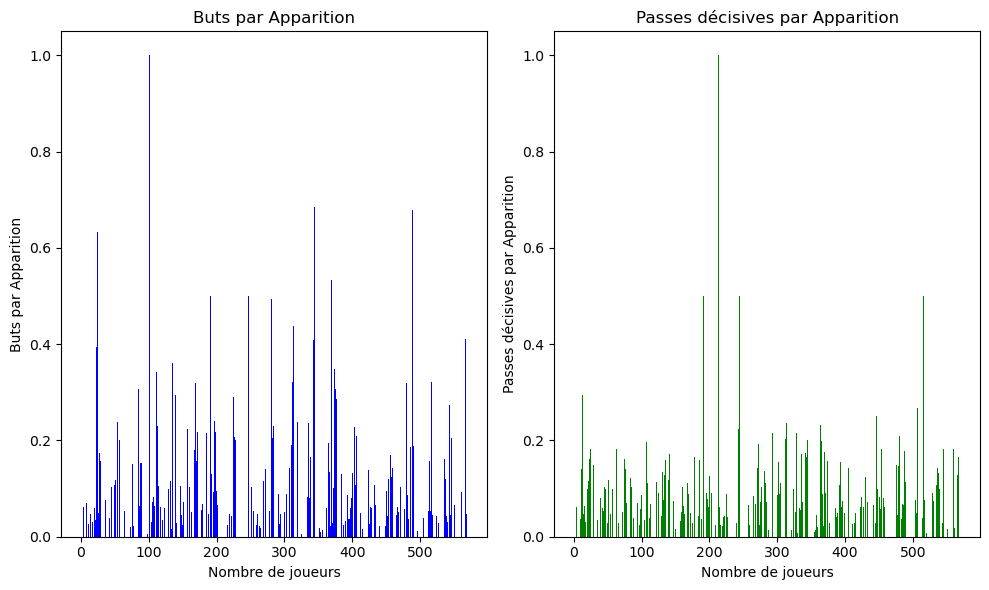

In [11]:
# Tracer le graphique
plt.figure(figsize=(10, 6))

# Graphique pour les buts par apparition
plt.subplot(1, 2, 1)
plt.bar(data.index, data['Buts par Appearances'], color='blue')
plt.xlabel('Nombre de joueurs')
plt.ylabel('Buts par Apparition')
plt.title('Buts par Apparition')

# Graphique pour les passes décisives par apparition
plt.subplot(1, 2, 2)
plt.bar(data.index, data['Passes décisives par Appearances'], color='green')
plt.xlabel('Nombre de joueurs')
plt.ylabel('Passes décisives par Apparition')
plt.title('Passes décisives par Apparition')

# Afficher le graphique
plt.tight_layout()
plt.show()

## Creation du table Statistique du Feature Buts par Appearances

In [12]:
quantiles = [0, 0.25, 0.5, 0.75, 1]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1'] 
summary_table = generate_summary_table('Buts par Appearances',data,quantiles=quantiles)
summary_table

,Buts par Appearances_Interval,Effectif,Fréquence,Effectif cumulé,Fréquence cumulée
0,-0.01-0.00,254,0.444834,254,0.444834
1,0.00-0.02,32,0.056042,286,0.500876
2,0.02-0.09,142,0.248687,428,0.749562
3,0.09-1.01,143,0.250438,571,1.000000


## Creation du table Statistique du Feature Assists per Apperances

In [13]:
quantiles = [0, 0.25, 0.5, 0.75, 1]
summary_table = generate_summary_table('Passes décisives par Appearances',data,quantiles)
summary_table

,Passes décisives par Appearances_Interval,Effectif,Fréquence,Effectif cumulé,Fréquence cumulée
0,-0.01-0.00,239,0.418564,239,0.418564
1,0.00-0.03,47,0.082312,286,0.500876
2,0.03-0.08,142,0.248687,428,0.749562
3,0.08-1.01,143,0.250438,571,1.000000


## Figure du relation entre age et nb de buts

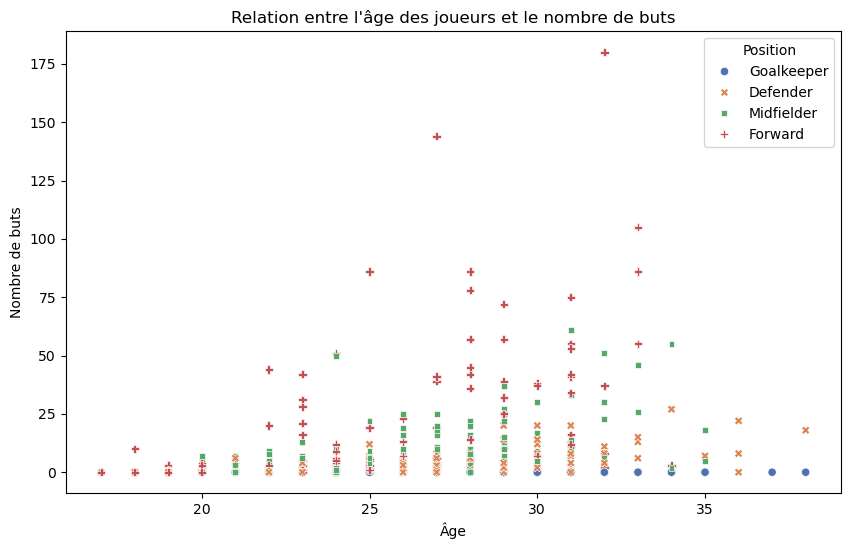

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Age', y='Goals', hue='Position', style='Position', palette='deep')
plt.title('Relation entre l\'âge des joueurs et le nombre de buts')
plt.xlabel('Âge')
plt.ylabel('Nombre de buts')
plt.legend(title='Position')
plt.show()

## Creation du table Statistique du Feature Position

In [15]:
summary_table_position = generate_summary_table('Position',data)
# Afficher le tableau récapitulatif
summary_table_position

,Position,Effectif,Fréquence
0,Defender,194,0.339755
1,Forward,110,0.192644
2,Goalkeeper,69,0.120841
3,Midfielder,198,0.346760


## Creation du table Statistique du Feature Age

In [16]:
quantiles = [0, 0.25, 0.5, 0.75, 1]
summary_table_age = generate_summary_table('Age',data,quantiles)
# Afficher le tableau récapitulatif
summary_table_age

,Age_Interval,Effectif,Fréquence,Effectif cumulé,Fréquence cumulée
0,16.99-22.00,148,0.259194,148,0.259194
1,22.00-26.00,166,0.290718,314,0.549912
2,26.00-29.00,138,0.241681,452,0.791594
3,29.00-38.01,119,0.208406,571,1.000000


## Figure Distribution de l'âge des joueurs

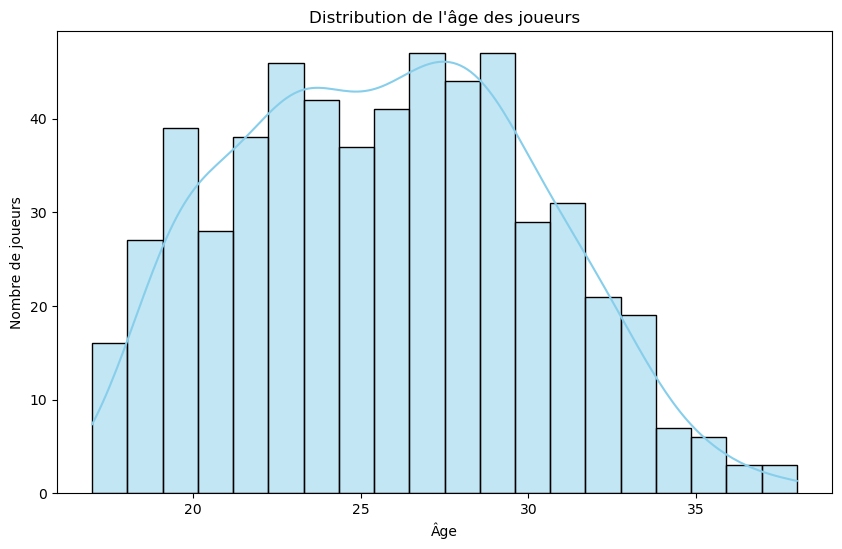

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Age', bins=20, kde=True, color='skyblue')
plt.title('Distribution de l\'âge des joueurs')
plt.xlabel('Âge')
plt.ylabel('Nombre de joueurs')
plt.show()

### Analyse MultiVariable ( Age , Goals per apperences , Assists per apperances )

#### Avec PCA

In [18]:
data_test = data[["Age","Passes décisives par Appearances","Buts par Appearances"]]
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 3 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               571 non-null    float64
 1   Passes décisives par Appearances  571 non-null    float64
 2   Buts par Appearances              571 non-null    float64
dtypes: float64(3)
memory usage: 13.5 KB


Il semble qu'il y ait un joueur dont l'âge est manquant dans les données donc on va trouver une solution pour remplir cette colonne 






In [19]:
scaler = StandardScaler()
data_test_scaled = scaler.fit_transform(data_test)  # Exclude categorical columns if any
data_test_scaled = pd.DataFrame(data_test_scaled,columns=data_test.columns)
data_test_scaled.head()

,Age,Passes décisives par Appearances,Buts par Appearances
0,0.507064,-0.635153,-0.567369
1,0.049665,-0.635153,-0.567369
2,-0.179034,-0.635153,-0.567369
3,-0.179034,0.663774,-0.228423
4,-0.636433,0.086474,-0.083161


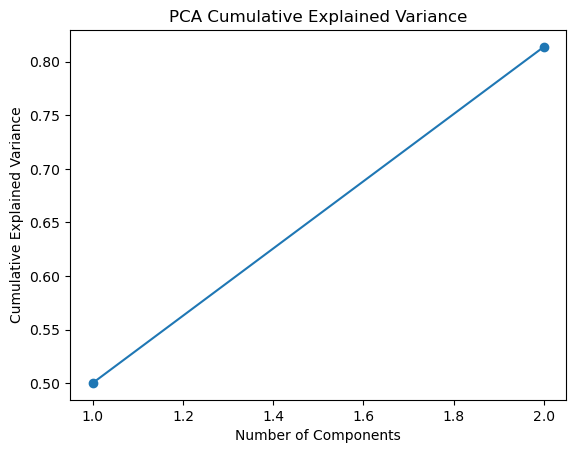

In [20]:
# Fit PCA
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(data_test_scaled)

# Plot explained variance ratio
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.show()

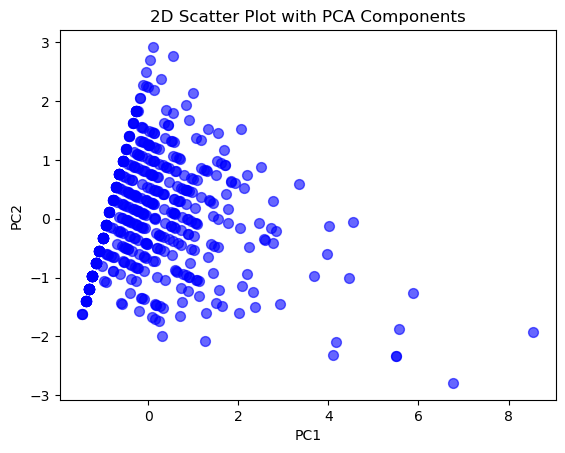

In [21]:
# Create a 2D scatter plot using the first two principal components
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], color='b', s=50, alpha=0.6)
plt.xlabel("PC1")  # Label for the first principal component
plt.ylabel("PC2")  # Label for the second principal component
plt.title("2D Scatter Plot with PCA Components")
plt.show()

<ul><li><p><strong>Application de PCA</strong> : Nous avons appliqué une analyse en composantes principales pour réduire la dimensionnalité des données à deux composantes principales. Cette technique nous aide à identifier les axes qui maximisent la variance des données.</p></li><li><p><strong>Interprétation des axes</strong> :</p><ul><li><strong>PC1</strong> : Premier composant principal, représentant la direction de la plus grande variance des données.</li><li><strong>PC2</strong> : Second composant principal, capturant la plus grande partie de la variance restante.</li></ul></li><li><p><strong>Visualisation en 2D</strong> : Le nuage de points sur les deux premiers composants principaux montre la distribution des observations. Chaque point représente une observation dans le nouvel espace réduit, permettant de détecter des patterns ou des groupes potentiellement significatifs.</p></li><li><p><strong>Analyse de la variance expliquée</strong> : Nous avons également examiné la part de variance expliquée par chaque composant principal pour évaluer l'efficacité de la réduction de dimensionnalité.</p></li></ul>

#### Avec Clustering (sur l'age)

In [22]:
# Define the age threshold
age_threshold = 25
# Create clusters based on the age threshold
data_test['Cluster'] = (data_test['Age'] > age_threshold).astype(int)

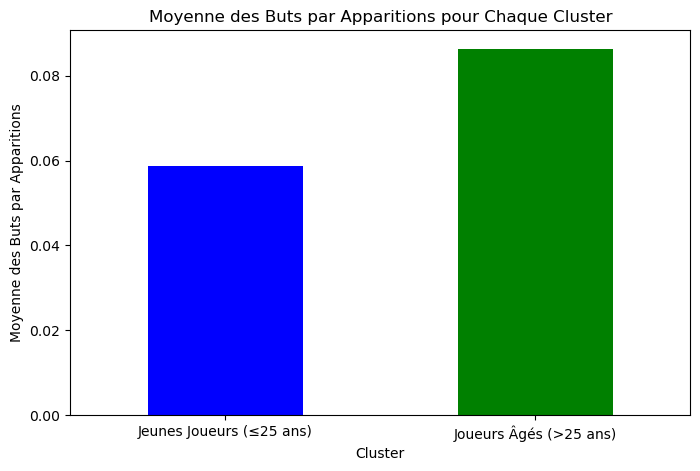

In [23]:
# Calculate the average of 'Buts par Appearances' for each cluster
average_goals_per_cluster = data_test.groupby('Cluster')['Buts par Appearances'].mean()

# Plotting the bar graph
plt.figure(figsize=(8, 5))
average_goals_per_cluster.plot(kind='bar', color=['blue', 'green'])
plt.title('Moyenne des Buts par Apparitions pour Chaque Cluster')
plt.xlabel('Cluster')
plt.ylabel('Moyenne des Buts par Apparitions')
plt.xticks(ticks=[0, 1], labels=['Jeunes Joueurs (≤25 ans)', 'Joueurs Âgés (>25 ans)'], rotation=0)
plt.show()

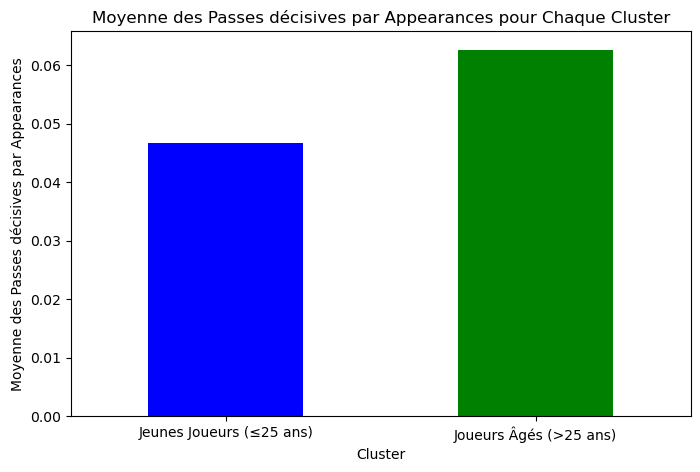

In [24]:
# Calculate the average of 'Buts par Appearances' for each cluster
average_goals_per_cluster = data_test.groupby('Cluster')['Passes décisives par Appearances'].mean()

# Plotting the bar graph
plt.figure(figsize=(8, 5))
average_goals_per_cluster.plot(kind='bar', color=['blue', 'green'])
plt.title('Moyenne des Passes décisives par Appearances pour Chaque Cluster')
plt.xlabel('Cluster')
plt.ylabel('Moyenne des Passes décisives par Appearances')
plt.xticks(ticks=[0, 1], labels=['Jeunes Joueurs (≤25 ans)', 'Joueurs Âgés (>25 ans)'], rotation=0)
plt.show()

Ces graphiques montre un écart significatif entre les deux groupes. Les joueurs âgés ont un ratio de buts par apparition et Passes décisives par Appearances nettement plus élevé que celui des jeunes joueurs. Cela suggère que l'expérience et l'âge peuvent influencer positivement la performance en termes de marquage de buts.

# 2. Question 2 (Relation entre % du tackle réussit avec nb but encassé)

## Creation du 2éme Codebook

In [25]:
# Convertir les colonnes en numérique, en traitant les erreurs
# Assurez-vous que la colonne est traitée comme des chaînes et retirez le symbole pourcentage
data['Tackle success %'] = data['Tackle success %'].astype(str).str.replace('%', '')

# Convertissez les valeurs nettoyées en numérique, transformant les non-convertis en NaN
data['Tackle success %'] = pd.to_numeric(data['Tackle success %'], errors='coerce')

# Maintenant, remplacez les NaN par 0 (ou toute autre valeur/méthode de votre choix)
data['Goals conceded'] = pd.to_numeric(data['Goals conceded'], errors='coerce')

average_tackles_by_category = data.groupby('Position')['Tackle success %'].mean()

# Afficher les moyennes des tacles pour chaque catégorie de joueurs
print(average_tackles_by_category)


Position
Defender      50.319588
Forward       69.000000
Goalkeeper          NaN
Midfielder    54.708333
Name: Tackle success %, dtype: float64


In [26]:
data['Tackle success %']

0       NaN
1       NaN
2       NaN
3      78.0
4      81.0
       ... 
566     NaN
567     NaN
568     NaN
569     NaN
570     NaN
Name: Tackle success %, Length: 571, dtype: float64

In [27]:
import pandas as pd

# Define the function to replace zero values
def replace_zero(row):
    # Use pd.isna to check for NaN values properly
    if pd.isna(row['Tackle success %']):
        if row['Position'] == 'Goalkeeper':
            return 0  # Goalkeepers keep zero
        else:
            # Get the average for the position, return 0 if not available
            return average_tackles_by_category.get(row['Position'], 0)
    else:
        return row['Tackle success %']  # Return the existing value if not NaN

# Assuming 'data' and 'average_tackles_by_category' have been defined earlier
# Apply the function across the DataFrame
data['Tackle success %'] = data.apply(replace_zero, axis=1)

# Display the updated 'Tackle success %' column to verify changes
print(data['Tackle success %'])

0       0.0
1       0.0
2       0.0
3      78.0
4      81.0
       ... 
566    69.0
567    69.0
568    69.0
569    69.0
570    69.0
Name: Tackle success %, Length: 571, dtype: float64


Nous avons noté que la colonne "Tackle Success %" contenait plusieurs valeurs manquantes (NaN) pour divers joueurs. Pour combler ces lacunes, au lieu de recourir à des moyennes générales ou à des méthodes de remplissage traditionnelles, nous avons calculé la moyenne de "Tackle Success %" pour chaque position spécifique. Ensuite, nous avons utilisé ces moyennes par position pour remplir les valeurs manquantes correspondant à chaque poste.

In [28]:
# Agrégation des données par équipe pour le pourcentage moyen de tacles réussis et la moyenne des buts encaissés
data_agg = data.groupby('Club').agg({
    'Tackle success %': 'mean',
    'Goals conceded': 'mean'  # Si chaque joueur a le même nombre, la moyenne par équipe est représentative
}).reset_index()

# Créer un codebook pour les variables agrégées
codebook = pd.DataFrame({
    'Variable': ['Pourcentage Tacles Réussis', 'Buts Encaissés'],
    'Description': ['Pourcentage moyen de tacles réussis par équipe', 'Nombre moyen de buts encaissés par équipe'],
    'Source': ['Données agrégées par équipe', 'Données agrégées par équipe'],
    'Remarques': ['Moyenne des pourcentages de tacles réussis par tous les joueurs de l\'équipe', 'Moyenne des buts encaissés enregistrés pour chaque joueur de l\'équipe']
})

# Afficher le codebook
print("Codebook pour l'analyse :")
codebook

Codebook pour l'analyse :


,Variable,Description,Source,Remarques
0,Pourcentage Tacles Réussis,Pourcentage moyen de tacles réussis par équipe,Données agrégées par équipe,Moyenne des pourcentages de tacles réussis par...
1,Buts Encaissés,Nombre moyen de buts encaissés par équipe,Données agrégées par équipe,Moyenne des buts encaissés enregistrés pour ch...


## Enregistrer le codebook dans un fichier CSV


In [29]:
codebook.to_csv('codebook_success_goals_conceded.csv', index=False)
print("\nDonnées agrégées par équipe :")
print(data_agg)


Données agrégées par équipe :
                        Club  Tackle success %  Goals conceded
0                    Arsenal         56.423611       70.307692
1                Aston-Villa         45.250000       68.923077
2   Brighton-and-Hove-Albion         41.869949       35.357143
3                    Burnley         46.279514      116.230769
4                    Chelsea         50.333333       79.923077
5             Crystal-Palace         51.935484      157.187500
6                    Everton         57.548387       98.181818
7                     Fulham         49.360000       24.083333
8               Leeds-United         47.192308        2.545455
9             Leicester-City         49.538978       87.846154
10                 Liverpool         47.794118       53.071429
11           Manchester-City         54.037037      103.454545
12         Manchester-United         52.967742       86.352941
13          Newcastle-United         54.333333       99.769231
14          Sheffield-Un

## Figure du Nombre total de buts concédés par club

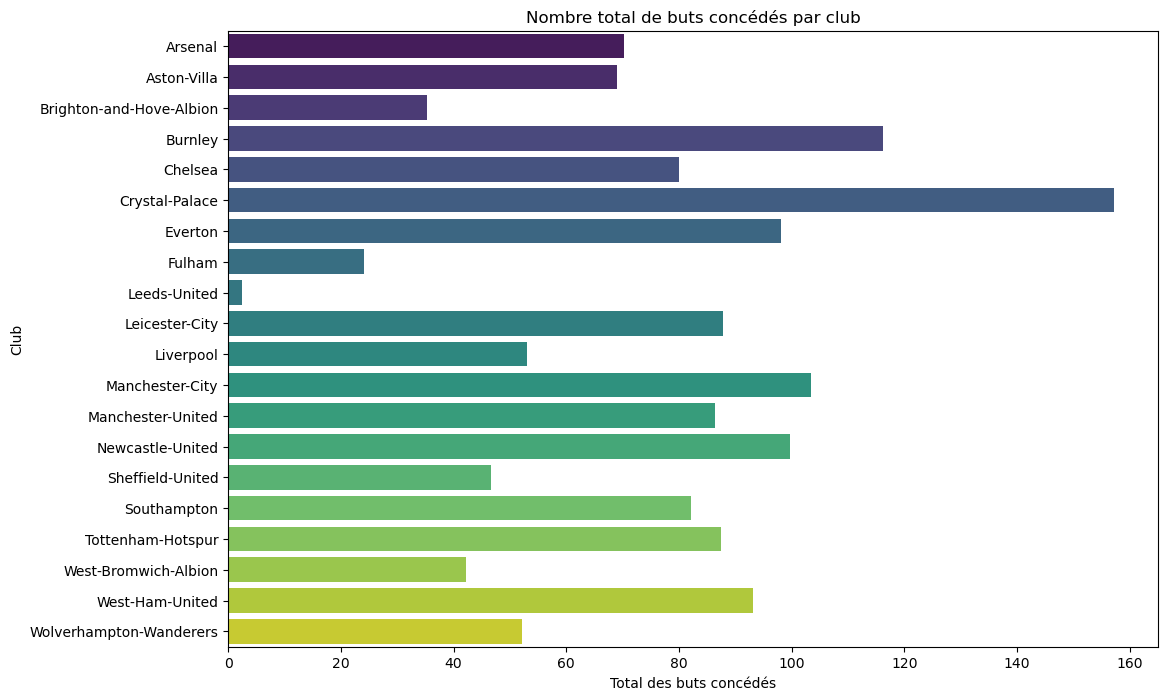

In [30]:
# Création du graphique
plt.figure(figsize=(12, 8))
sns.barplot(x='Goals conceded', y='Club', data=data_agg, palette='viridis')  # Correction ici
plt.title('Nombre total de buts concédés par club')
plt.xlabel('Total des buts concédés')
plt.ylabel('Club')
plt.show()

## Creation du table Statistique du Feature Tackle success %

In [31]:
# Définir les intervalles pour 'Tackle success %'
quantiles = [0, 0.25, 0.5, 0.75, 1]
summary_table_tackle = generate_summary_table('Tackle success %',data_agg,quantiles)
summary_table_tackle

,Tackle success %_Interval,Effectif,Fréquence,Effectif cumulé,Fréquence cumulée
0,41.86-45.63,5,0.25,5,0.25
1,45.63-49.45,5,0.25,10,0.50
2,49.45-52.19,5,0.25,15,0.75
3,52.19-57.56,5,0.25,20,1.00


## Creation du table Statistique du Feature Goals conceded

In [32]:
# Définir les intervalles pour 'Tackle success %'
quantiles = [0, 0.25, 0.5, 0.75, 1]
summary_table_goals = generate_summary_table('Goals conceded',data_agg,quantiles)
summary_table_goals

,Goals conceded_Interval,Effectif,Fréquence,Effectif cumulé,Fréquence cumulée
0,2.54-50.73,5,0.25,5,0.25
1,50.73-81.04,5,0.25,10,0.50
2,81.04-94.41,5,0.25,15,0.75
3,94.41-157.20,5,0.25,20,1.00


In [33]:
clubs=data_agg['Club']
data_agg = data_agg[['Goals conceded','Tackle success %']]

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_agg_scaled = scaler.fit_transform(data_agg)  # Exclude categorical columns if any
data_agg_scaled = pd.DataFrame(data_agg_scaled,columns=data_agg.columns)
data_agg_scaled.head()

,Goals conceded,Tackle success %
0,-0.117433,1.669646
1,-0.157720,-0.944298
2,-1.134354,-1.735024
3,1.218743,-0.703455
4,0.162336,0.244892


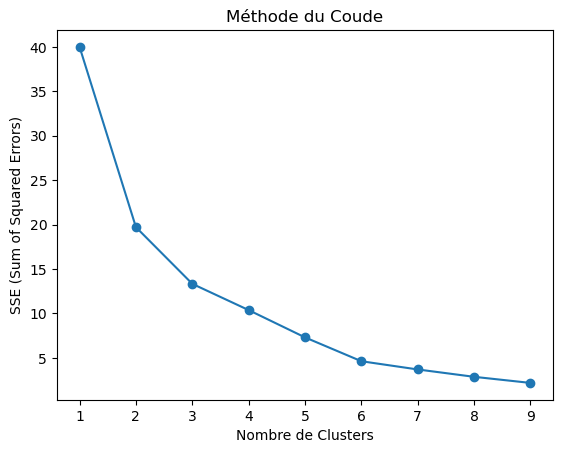

In [35]:
# Détermination du nombre optimal de clusters avec la méthode du coude
sse = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_agg_scaled)
    sse.append(kmeans.inertia_)

# Graphique du coude
plt.plot(k_range, sse, '-o')
plt.xlabel("Nombre de Clusters")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("Méthode du Coude")
plt.show()

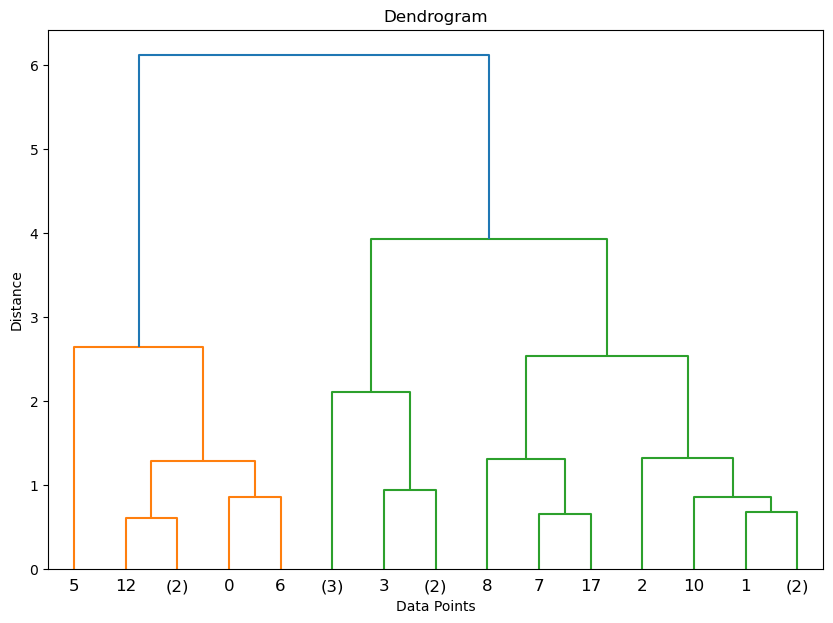

In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Perform hierarchical clustering
linkage_matrix = linkage(data_agg_scaled, method='ward')

# Create the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=15)  # Adjust 'p' to show the final clusters
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

Après avoir analysé la méthode du coude et le dendrogramme, nous avons déterminé que le nombre optimal de clusters pour l'algorithme KNN est de 2.

In [37]:
# Choisissez le nombre de clusters
optimal_clusters = 2  # À modifier selon votre résultat du coude

# Appliquer K-means
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_agg_scaled["Cluster"] = kmeans.fit_predict(data_agg_scaled)


In [38]:
data_agg["Cluster"]=data_agg_scaled["Cluster"]
data_agg.head()

,Goals conceded,Tackle success %,Cluster
0,70.307692,56.423611,1
1,68.923077,45.250000,0
2,35.357143,41.869949,0
3,116.230769,46.279514,1
4,79.923077,50.333333,1


In [39]:
summary_table = data_agg.groupby('Cluster').agg({
    'Goals conceded': ['mean', 'std'],  # Remplacez 'Buts concédés' par le nom exact de votre colonne
    'Tackle success %': ['mean', 'std']  # Remplacez '% succès des tacles' par le nom exact de votre colonne
})

# Renommer les colonnes pour correspondre à vos besoins
summary_table.columns = ['Moyenne des buts concédés', 'Écart-type des buts concédés', 
                         'Moyenne du % de succès des tacles', 'Écart-type du % de succès des tacles']

# Réinitialiser l'index si nécessaire
summary_table.reset_index(inplace=True)

# Afficher le tableau récapitulatif
summary_table

,Cluster,Moyenne des buts concédés,Écart-type des buts concédés,Moyenne du % de succès des tacles,Écart-type du % de succès des tacles
0,0,50.545480,27.580386,46.159501,2.739705
1,1,98.142039,24.611024,52.413527,3.371926


<ul><li><strong>Cluster 0 :</strong> Bien qu'avec un taux de succès des tacles modéré, les buts concédés restent bas, suggérant d'autres facteurs défensifs à l'œuvre au-delà des tacles réussis.</li><li><strong>Cluster 1 :</strong> Malgré un meilleur taux de succès des tacles, le nombre élevé de buts concédés indique que l'efficacité des tacles peut être affaiblie par des éléments tels que le positionnement défensif ou la qualité de l'adversaire.</li><li><strong>Relation générale :</strong> L'analyse révèle une relation complexe et non linéaire entre succès des tacles et buts concédés, avec des influences possibles comme le style de jeu et la coordination défensive, qui modulent cette dynamique.</li></ul>